In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy import stats

from ipywidgets import interact, fixed

In [3]:
def sample_distributions(mu_neg, mu_pos, sd_neg, sd_pos,
                         n_neg, n_pos, fnr, fpr,
                         clip_low, clip_high):
    """Returns subsamples and observations from two normal 
    distributions.
    
    - mu_neg     mean of 'negative' samples
    - mu_pos     mean of 'positive' samples
    - sd_neg     standard deviation of 'negative' samples
    - sd_pos     standard deviation of 'positive' samples    
    - n_neg      number of subsampled data points (negatives)
    - n_pos      number of subsampled data points (positives)
    - fnr        false negative rate (positives assigned to negative class)
    - fpr        false positive rate (negatives assigned to positive class)
    - clip_low   low value for clipping samples
    - clip_high  high value for clipping samples    
    """
    # subsamples
    samples = (clip(stats.norm.rvs(mu_neg, sd_neg, size=n_neg), clip_low, clip_high),
               clip(stats.norm.rvs(mu_pos, sd_pos, size=n_pos), clip_low, clip_high))
    # observed samples, including FPR and FNR
    [shuffle(s) for s in samples]
    obs_neg = concatenate((samples[0][:int((1-fpr)*n_neg)], 
                           samples[1][int((1-fnr)*n_pos):]))
    obs_pos = concatenate((samples[1][:int((1-fnr)*n_pos)],
                           samples[0][int((1-fpr)*n_neg):]))
    # return subsamples and observations
    return ((samples[0], samples[1]), (obs_neg, obs_pos))

def multiple_samples(n_samp=1000,
                     mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5,
                     n_neg=100, n_pos=100,
                     fnr=0, fpr=0,
                     clip_low=0, clip_high=100):
    """Returns the distribution of P-values obtained from subsampled
    and observed (with FNR/FPR) normal distributions, over n_samp
    repetitions.
    
    - n_samp     number of times to (re)sample from the distribution
    - mu_neg     mean of 'negative' samples
    - mu_pos     mean of 'positive' samples
    - sd_neg     standard deviation of 'negative' samples
    - sd_pos     standard deviation of 'positive' samples    
    - n_neg      number of subsampled data points (negatives)
    - n_pos      number of subsampled data points (positives)
    - fnr        false negative rate (positives assigned to negative class)
    - fpr        false positive rate (negatives assigned to positive class)
    - clip_low   low value for clipping samples
    - clip_high  high value for clipping samples 
    """
    p_sam, p_obs = [], []
    for n in range(n_samp):
        samples, obs = sample_distributions(mu_neg, mu_pos, sd_neg, sd_pos,
                                            n_neg, n_pos, fnr, fpr,
                                            clip_low, clip_high)
        t_sam = stats.ttest_ind(samples[0], samples[1], equal_var=False)
        t_obs = stats.ttest_ind(obs[0], obs[1], equal_var=False)        
        p_sam.append(t_sam[1])
        p_obs.append(t_obs[1])
    # return the P-values
    return (p_sam, p_obs)
        

def draw_multiple_samples(n_samp=1000,
                          mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5,
                          n_neg=100, n_pos=100,
                          fnr=0, fpr=0,
                          clip_low=0, clip_high=100):
    """Plots the distribution of P-values obtained from subsampled
    and observed (with FNR/FPR) normal distributions, over n_samp
    repetitions.
    
    - n_samp     number of times to (re)sample from the distribution
    - mu_neg     mean of 'negative' samples
    - mu_pos     mean of 'positive' samples
    - sd_neg     standard deviation of 'negative' samples
    - sd_pos     standard deviation of 'positive' samples    
    - n_neg      number of subsampled data points (negatives)
    - n_pos      number of subsampled data points (positives)
    - fnr        false negative rate (positives assigned to negative class)
    - fpr        false positive rate (negatives assigned to positive class)
    - clip_low   low value for clipping samples
    - clip_high  high value for clipping samples    
    """
    p_sam, p_obs = multiple_samples(n_samp, mu_neg, mu_pos,
                                    sd_neg, sd_pos, n_neg, n_pos,
                                    fnr, fpr, clip_low, clip_high)
    # plot P-values against each other
    p = loglog(p_sam, p_obs, 'o', alpha=0.3)
    ax = gca()
    ax.set_xlabel("'Real' subsample P-value")
    ax.set_ylabel("Observed subsample P-value")
    ax.set_title("reps=%d $n_{neg}$=%d $n_{pos}$=%d FNR=%.02f FPR=%.02f" %
                 (n_samp, n_neg, n_pos, fnr, fpr))
    # Add y=x lines, P=0.05
    lims = [min([ax.get_xlim(), ax.get_ylim()]),
            max([(0.05, 0.05), max([ax.get_xlim(), ax.get_ylim()])])]
    loglog(lims, lims, 'k', alpha=0.75)
    ax.set_aspect('equal')
    vlines(0.05, min(ax.get_ylim()), max(max(ax.get_ylim()), 0.05), color='red') # add P=0.05 lines
    hlines(0.05, min(ax.get_xlim()), max(max(ax.get_xlim()), 0.05), color='red')
    

def draw_sample_comparison(mu_neg=80, mu_pos=90, sd_neg=5, sd_pos=5,
                           n_neg=100, n_pos=100,
                           fnr=0, fpr=0,
                           clip_low=0, clip_high=100,
                           num_bins=50,
                           xmin=50, xmax=100, points=100,
                           subsample=True,
                           negcolor='blue', poscolor='green'):
    """Renders a matplotlib plot of normal distributions and subsamples,
    and returns t-test P values that the means of the two subsamples are
    equal, with and without FNR/FPR.
    
    - mu_neg     mean of 'negative' samples
    - mu_pos     mean of 'positive' samples
    - sd_neg     standard deviation of 'negative' samples
    - sd_pos     standard deviation of 'positive' samples    
    - n_neg      number of subsampled data points (negatives)
    - n_pos      number of subsampled data points (positives)
    - fnr        false negative rate (positives assigned to negative class)
    - fpr        false positive rate (negatives assigned to positive class)
    - clip_low   low value for clipping samples
    - clip_high  high value for clipping samples
    - bins       number of bins for histogram
    - xmin       x-axis lower limit
    - xmax       x-axis upper limit
    - points     number of points for plotting PDF
    - subsample  Boolean: True plots subsamples
    """
    x = linspace(points, xmin, xmax)
    # Normal PDFs
    norms = (normpdf(x, mu_neg, sd_neg), normpdf(x, mu_pos, sd_pos))
    # Get subsamples and observations
    samples, obs = sample_distributions(mu_neg, mu_pos, sd_neg, sd_pos,
                                        n_neg, n_pos, fnr, fpr,
                                        clip_low, clip_high)
    # Plot distribution and samples
    plot(x, norms[0], color=negcolor)
    plot(x, norms[1], color=poscolor)
    if subsample:
        h_neg = hist(samples[0], num_bins, normed=1, facecolor=negcolor, alpha=0.5)
        h_pos = hist(samples[1], num_bins, normed=1, facecolor=poscolor, alpha=0.5)
    ax = gca()
    ax.set_xlabel("value")
    ax.set_ylabel("frequency")
    # Calculate t-tests
    t_sam = stats.ttest_ind(samples[0], samples[1], equal_var=False)
    t_obs = stats.ttest_ind(obs[0], obs[1], equal_var=False)
    ax.set_title("$P_{real}$: %.02e $P_{obs}$: %.02e" % (t_sam[1], t_obs[1]))

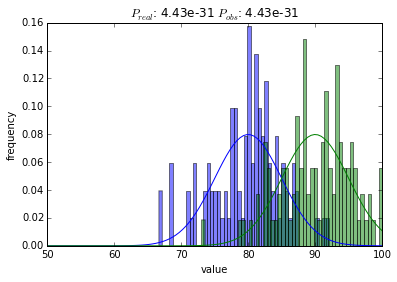

In [4]:
draw_sample_comparison()

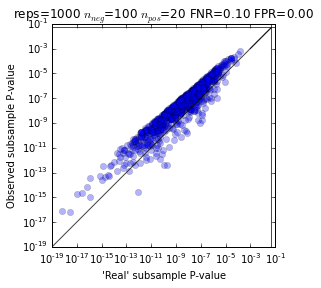

In [8]:
p_vals = draw_multiple_samples(fnr=0.1, fpr=0, n_pos=20, n_neg=100)

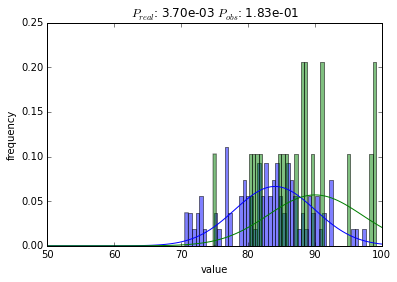

In [6]:
interact(draw_sample_comparison,
         mu_neg=(60, 99, 1), mu_pos=(60, 99, 1),
         sd_neg=(0, 15, 1), sd_pos=(0, 15, 1),
         n_neg=(0, 150, 1), n_pos=(0, 150, 1),
         fnr=(0, 1, 0.01), fpr=(0, 1, 0.01),
         clip_low=fixed(0), clip_high=fixed(100),
         num_bins=fixed(50), xmin=fixed(50),
         xmax=fixed(100), points=fixed(100),
         subsample=True, negcolor=fixed('blue'),
         poscolor=fixed('green'))

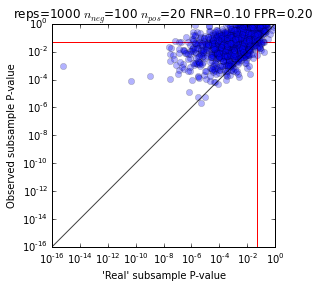

In [7]:
interact(draw_multiple_samples,
         mu_neg=(60, 99, 1), mu_pos=(60, 99, 1),
         sd_neg=(0, 15, 1), sd_pos=(0, 15, 1),
         n_neg=(0, 150, 1), n_pos=(0, 150, 1),
         fnr=(0, 1, 0.01), fpr=(0, 1, 0.01),
         clip_low=fixed(0), clip_high=fixed(100))